In [5]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<oov>'
training_size = 20000
!curl https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json --output ./tmp/sarcasm.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5511k  100 5511k    0     0   405k      0  0:00:13  0:00:13 --:--:--  725k


In [3]:
with open("./tmp/sarcasm.json", "r") as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [6]:
training_sentences = np.array(sentences[0:training_size])
testing_sentences = np.array(sentences[training_size:])
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

num_epochs = 30
history = model.fit(training_padded,
                     training_labels,
                     epochs=num_epochs,
                     validation_data=(testing_padded,testing_labels))

Epoch 1/30
625/625 [==============================] - 1s 1ms/step - loss: 0.5710 - accuracy: 0.6980 - val_loss: 0.4029 - val_accuracy: 0.8314
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3187 - accuracy: 0.8702 - val_loss: 0.3425 - val_accuracy: 0.8553
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.2404 - accuracy: 0.9065 - val_loss: 0.3391 - val_accuracy: 0.8562
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.1934 - accuracy: 0.9259 - val_loss: 0.3743 - val_accuracy: 0.8402
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.1604 - accuracy: 0.9396 - val_loss: 0.3790 - val_accuracy: 0.8524
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.1367 - accuracy: 0.9507 - val_loss: 0.4083 - val_accuracy: 0.8496
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.1167 - accuracy: 0.9610 - val_loss: 0.4462 - val_accuracy: 0.8462
Epoch 

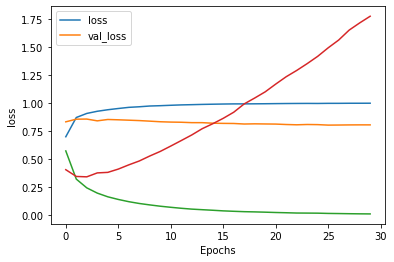

In [13]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
    plt.plot((history.history[string]))
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

In [14]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <oov> store clerk sues over secret 'black <oov> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
import io

out_v = io.open('./tmp/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./tmp/meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [17]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.9859923e-01]
 [3.8753444e-07]]
